## Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 분석 환경 설정

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Cuda Device :', device)

Cuda Device : cuda


## HyperParameter 지정

In [ ]:
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

## 데이터 불러오기

In [ ]:
train_data = datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True, download = False, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False, transform = transforms.ToTensor())

In [ ]:
print(len(train_data), len(test_data))

60000 10000


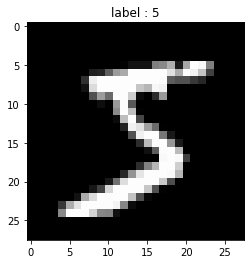

In [ ]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

## 미니 배치 구성

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_data, 
                                           batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [ ]:
print('{:23s} |    {}'.format('first_batch[0][0]', first_batch[0][0].shape))
print('{:23s} |    {}'.format('first_batch[0][0][0]', first_batch[0][0][0].shape))

first_batch[0][0]       |    torch.Size([1, 28, 28])
first_batch[0][0][0]    |    torch.Size([28, 28])


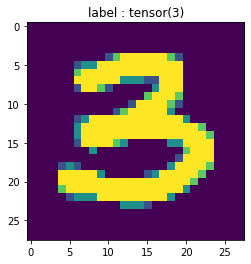

In [ ]:
plt.imshow(first_batch[0][0][0])
plt.title('label : %s' % first_batch[1][0])
plt.show()

## CNN 구조 설계

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)         # conv1 통과
    x = F.relu(x)             # ReLU 활성함수 적용
    x = self.conv2(x)         # conv2 통과
    x = F.relu(x)             # ReLU 활성함수 적용

    x = F.max_pool2d(x,2)     # 2*2 filter로 max-pooling
    x = self.dropout1(x)      # 사전에 정의한 0.25 확률의 dropout1을 반영
    x = torch.flatten(x, 1)   # 고차원 torch를 1차원 벡터로 변환 = 64*12*12
    x = self.fc1(x)           # 9216 크기의 벡터를 128 크기의 벡터로 학습하는 fc1 통과
    x = F.relu(x)             # ReLU 활성함수 적용
    x = self.dropout2(x)      # 사전에 정의한 0.5 확률의 dropout1을 반영
    x = self.fc2(x)           # 128 크기의 벡터를 10 크기의 벡터로 학습하는 fc2 통과

    # 최종 출력값 : log-softmax를 사용한다.
    # softmax가 아닌 log_softmax를 사용하면 연산 속도를 높일 수 있다.
    output = F.log_softmax(x, dim=1)

    return output

## Optimizer 및 손실 함수 정의

In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss( )

## 모델 학습

In [ ]:
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        # 이전 반복 시행에서 저장된 optimizer의 gradient를 초기화
        optimizer.zero_grad()

        # Feed Forward (미니 배치를 모델에 통과시킴)
        output = model(data)
        
        # 손실함수를 통해 Gradient 계산
        loss = criterion(output, target)
        loss.backward()

        # Gradient를 통해 모델의 가중치 업데이트
        optimizer.step()

        # 학습 1000번마다 손실함수 출력
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 1000	Loss: 0.213
Train Step: 2000	Loss: 0.252
Train Step: 3000	Loss: 0.057
Train Step: 4000	Loss: 0.216
Train Step: 5000	Loss: 0.008
Train Step: 6000	Loss: 0.085
Train Step: 7000	Loss: 0.018
Train Step: 8000	Loss: 0.020
Train Step: 9000	Loss: 0.014
Train Step: 10000	Loss: 0.072
Train Step: 11000	Loss: 0.007
Train Step: 12000	Loss: 0.019
Train Step: 13000	Loss: 0.091
Train Step: 14000	Loss: 0.069
Train Step: 15000	Loss: 0.172
Train Step: 16000	Loss: 0.071
Train Step: 17000	Loss: 0.088
Train Step: 18000	Loss: 0.016


## 모델 평가

In [ ]:
model.eval()
correct = 0
for data, target in test_loader:
#     data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)
    output = model(data)

    # log-softmax 값이 가장 큰 인덱스를 예측값으로 저장.
    prediction = output.data.max(1)[1]

    
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Accuracy: 98.97%
